In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png')
from IPython.core.pylabtools import figsize
figsize(10, 6) # Width and hight
#plt.style.use('seaborn-white')

# 4.1 Getting started with classification – Breast cancer diagnosis

In this exercise, we will consider the data set `data/biopsy.csv` with data from breast biopsies, for the purpose of diagnosing breast cancer. For each patient, the data set contains nine different attributes (clump thickness, uniformity of cell size, uniformity of cell shape, marginal adhesion, single epithelial cell size, bare nuclei, bland chromatin, normal nucleoli and mitoses) scored on a scale from $1$ to $10$, as well as the physician’s diagnosis (malign or benign).

## Dataset
This data frame `biopsy` contains the following columns:  
`ID`: sample code number (not unique).  
`V1`: clump thickness.  
`V2`: uniformity of cell size.  
`V3`: uniformity of cell shape.  
`V4`: marginal adhesion.  
`V5`: single epithelial cell size.  
`V6`: bare nuclei (16 values are missing).  
`V7`: bland chromatin.  
`V8`: normal nucleoli.  
`V9`: mitoses.  
`class`: "benign" or "malignant".  

## a)
Load and familiarize yourself with the data set, using, e.g.`info()`, `describe()`, `pandas.plotting.scatter_matrix()` and `print()`.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   683 non-null    int64  
 1   ID      683 non-null    object 
 2   V1      683 non-null    int64  
 3   V2      683 non-null    int64  
 4   V3      683 non-null    int64  
 5   V4      683 non-null    int64  
 6   V5      683 non-null    int64  
 7   V6      683 non-null    float64
 8   V7      683 non-null    int64  
 9   V8      683 non-null    int64  
 10  V9      683 non-null    int64  
 11  class   683 non-null    object 
dtypes: float64(1), int64(9), object(2)
memory usage: 64.2+ KB
   index       ID  V1  V2  V3  V4  V5    V6  V7  V8  V9   class
0      0  1000025   5   1   1   1   2   1.0   3   1   1  benign
1      1  1002945   5   4   4   5   7  10.0   3   2   1  benign
2      2  1015425   3   1   1   1   2   2.0   3   1   1  benign
3      3  1016277   6   8   8   1   3   4.0   3   7   1  b

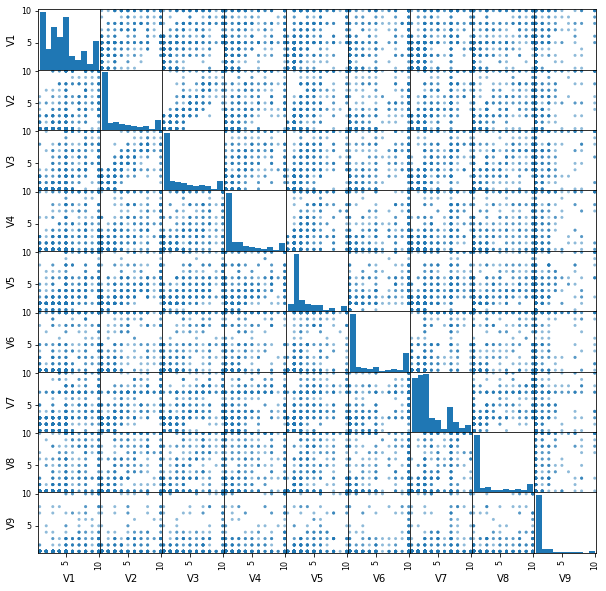

In [30]:
# url = 'data/biopsy.csv'
url = 'https://uu-sml.github.io/course-sml-public/data/biopsy.csv'
biopsy = pd.read_csv(url, na_values='?', dtype={'ID': str}).dropna().reset_index()
biopsy.info()
#print(biopsy.describe()) 
print(biopsy.head())
pd.plotting.scatter_matrix(biopsy.iloc[:, 2:11], figsize=(10,10))
plt.show()
print

## b)
Split the data randomly into a training set and a test set of approximately similar size.

In [34]:
print(biopsy.shape)
np.random.seed(1)

#Choosing 200 random row numbers from 0-auto.shape[0]
train_rows = np.random.choice(biopsy.shape[0], size=300, replace=False)

#Creating a bool array where True means that that row is in training data
train_index = biopsy.index.isin(train_rows)

biopsy_train_set = biopsy.iloc[train_index]


biopsy_test_set = biopsy.iloc[~train_index]

print(biopsy_test_set.shape)

(683, 12)
(383, 12)


## c) Logistic regression <a id='4.1-c'></a>
Perform logistic regression with `class` as output variable and `V3`, `V4` and `V5` as input variables. Do a prediction on the test set, and compute (i) the fraction of correct predictions and (ii) the confusion matrix (using, for examnple, `pandas.crosstab()`). The commands `skl_lm.LogisticRegression()` and `model.predict()` are useful. Is the performance any good, and what does the confusion matrix tell you?

In [37]:
model = skl_lm.LogisticRegression(solver='lbfgs')

X_train = biopsy_train_set[['V3','V4','V5']]
Y_train = biopsy_train_set['class']
X_test = biopsy_test_set[['V3','V4','V5']]
Y_test = biopsy_test_set['class']

model.fit(X_train,Y_train)
print('Model summary:')
print(model)
model.get_params()

Model summary:
LogisticRegression()


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [21]:
predict_prob = model.predict_proba(X_test)
print('The class order in the set is:')
print(model.classes_)
print('Examples of predicted probabilities for the above classes:')
predict_prob[0:5]

The class order in the set is:
['benign' 'malignant']
Examples of predicted probabilities for the above classes:


array([[0.01431778, 0.98568222],
       [0.96839691, 0.03160309],
       [0.98883578, 0.01116422],
       [0.99496543, 0.00503457],
       [0.83225441, 0.16774559]])

In [23]:
prediction = np.empty(len(X_test), dtype=object)
prediction = np.where(predict_prob[:,0]>=0.5, 'benign','malignant')

prediction[0:5]

array(['malignant', 'benign', 'benign', 'benign', 'benign'], dtype='<U9')

In [28]:
print('Confusion matrix: \n')
print(pd.crosstab(prediction,Y_test),'\n')
print(f"Accuracy: {np.mean(prediction == Y_test):.3f}")
print()

Confusion matrix: 

class      benign  malignant
row_0                       
benign        216         12
malignant       9        106 

Accuracy: 0.939


## d) LDA
Repeat [(c)](#4.1-c) using LDA. A useful command is `sklearn.discriminant_analysis.LinearDiscriminantAnalysis()`. `sklearn.discriminant_analysis` is imported as `skl_da`

## e) QDA
Repeat [(c)](#4.1-c) using QDA. A useful command is `sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()`.

## f) KNN
Repeat [(c)](#4.1-c) using $k$-NN (with $k = 1$). A useful commands is `sklearn.neighbors.KNeighborsClassifier()`.

## g) Try different values for KNN
Use a `for`-loop to explore the performance of $k$-NN for different values of $k$, and plot the fraction of correct
predictions as a function of $k$.

## h) ROC for logistic regression
Use a `for`-loop to explore how the true and false positive rates in logistic regression are affected by different threshold values, and plot the result as a `ROC curve`. (see Figure 4.7 and Table 4.1 in the book).

## i)
Try to find another set of inputs (perhaps by also considering transformations of the attributes) which gives a better result than you have achieved so far. You may also play with the threshold values. (“Better” is on purpose left vague. For this problem, the implications of a false negative (=`benign`) misclassification is probably more severe than a false positive (=`malignant`) misclassification.)

# 4.2 Decision boundaries
The following code generates some data with $x_1$ and $x_2$ both in $[0, 10]$ and $y$ either $0$ or $1$, and plots the decision boundary for a logistic regression model.

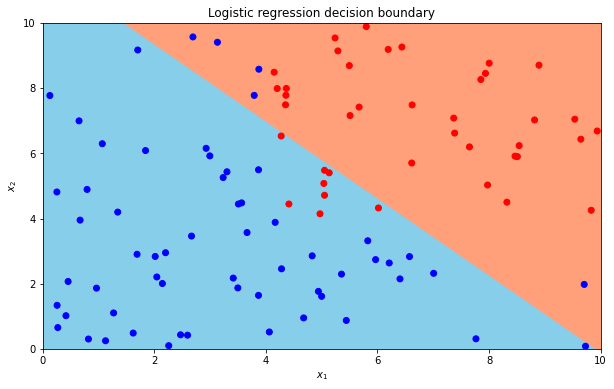

In [38]:
# generate data
np.random.seed(2)
N = 100
x1 = np.random.uniform(0, 10, N)
x2 = np.random.uniform(0, 10, N)
y = np.ones(N)
y[x1<4] = 0
y[x2<4] = 0
X = pd.DataFrame({'x1': x1, 'x2': x2})

# learn a logistic regression model
model = skl_lm.LogisticRegression(solver='lbfgs')
model.fit(X, y)

# classify the points in the whole domain
res = 0.01   # resolution of the squares
xs1 = np.arange(0, 10 + res, res)
xs2 = np.arange(0, 10 + res, res)
xs1, xs2 = np.meshgrid(xs1, xs2)    # Creating the grid for all the data points
X_all = pd.DataFrame({'x1': xs1.flatten(), 'x2': xs2.flatten()})
prediction = model.predict(X_all)

from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list('mycmap', ['skyblue', 'lightsalmon'])
plt.imshow(prediction.reshape(xs1.shape[0],-1),
           cmap=mycmap,
           origin='lower',
           extent=[0,10,0,10],
           aspect='auto')

# Plot of the data points and their label
plt.scatter(x1, x2, c=y, cmap='bwr') # blue - white -red colormap

plt.title('Logistic regression decision boundary')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## (a) 
Run the code and verify that it reproduces the figure, and make sure you understand the figure. What is the misclassification rate here?

## (b) 
Modify the code to plot the decision boundary for a LDA classifier. What differences do you see? What is the misclassification rate?

## (c) 
Modify the code to plot the decision boundary for a QDA classifier. What differences do you see? What is the misclassification rate?

## (d) 
Modify the code to plot the decision boundary for a $k$-NN classifier. What differences do you see? What is the misclassification rate?

## (e) 
What happens with the decision boundary for logistic regression if you include the term $x_1x_2$ as an input? What is the misclassification rate?

# 4.3 Why not linear regression?
In this exercise, we explore why linear regression might not be well suited for classification problems.

## (a) 
Construct and plot a data set as follows: Let $x_i$ be samples $x_i = i$ in a sequence from $i = 1$ to $i = 40$. Let $y_i = 0$ for all $i = 1 : 40$, except for $i = 34, 38, 39, 40$ where $y_i = 1$. Hence, $y$ belongs to either of two classes, $0$ and $1$.

## (b) 
Now, the problem is to fit a model which is able to predict the output $y$ from the input $x$. Start with a linear regression model (command `skl_lm.LinearRegression()`), and simply threshold its predictions at 0.5 (the average of 0 and 1, the two classes). Plot the prediction. How good is the prediction?

## (c) 
Try instead logistic regression using `skl_lm.LogisticRegression()` command (set the parameter `C` to $1000$) and plot the prediction. How good is the prediction, and what advantages does logistic regression have over linear regression for this classification problem?  

# 4.4 k-NN
In this exercise, we are going to explore an important user aspect of $k$-NN.

## (a) 
Make $200$ draws $x_1$ from a $\mathcal{N}(0, 1^2)$ distribution, and $200$ draws $x_2$ from $\mathcal{N}(0, 10^4)$. Also construct $y$ such that $y = 1$ if $x_1 \cdot x_2$ is positive, and $0$ otherwise. Split the data set randomly into a test and a training data set (equally sized).

## (b) 
Use $k$-NN (choose $k$ yourself) to predict the test output $y$ using $x_1$ and $x_2$ as inputs. How well do you perform?

## (c) 
Now replace $x_2$ with $200$ draws from $\mathcal{N}(0, 1^2)$, and perform $k$-NN classification anew. How well do you perform this time? Explain the difference!

## (d) 
Explore how the `sklearn.preprocessing.scale()` function can help for such problems encountered in (b)!

# 4.5 Multiclass classification
In the course, we have focused on the classification problem for 2 classes. The methods can, however, be generalized to more than two classes. In `Python`, the commands `skl_da.LinearDiscriminantAnalysis()`, `skl_da.QuadraticDiscriminantAnalysis()` and `skl_nb.KNeighborsClassifier()` can all be used directly for multi-class problems as well, which we will do in this exercise.

## (a)
Load and familiarize yourself with the data set `iris`, and split it randomly into a training and a test data set.

**Description**

This famous (Fisher's or Anderson's) `iris` data set gives the measurements in centimeters of the variables sepal length and width and petal length and width, respectively, for $50$ flowers from each of $3$ species of iris. The species are Iris setosa, versicolor, and virginica.

**Format**

iris is a data frame with $150$ cases (rows) and $5$ variables (columns) named `Sepal.Length`, `Sepal.Width`, `Petal.Length`, `Petal.Width`, and `Species`.

In [ ]:
# url = 'data/iris.csv'
url = 'https://uu-sml.github.io/course-sml-public/data/iris.csv'
iris = pd.read_csv(url)

## (b)
Use all inputs (`Sepal.Length`, `Sepal.Width`, `Petal.Length`, `Petal.Width`) to predict the output `Species` (`setosa`,
`versicolor` and `virginica`) using LDA, QDA, and $k$-NN, respectively.